In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Use for GPU utilization in conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [3]:
# Read in train and test data
train_df = pd.read_csv('../data/cleaned_study_data/study_train.csv', index_col= 'Unnamed: 0')
test_df = pd.read_csv('../data/cleaned_study_data/study_test.csv', index_col= 'Unnamed: 0')

In [4]:
train_df.head()

,time,Power,Oxygen,Cadence,HR,RF
0,3,0.0,602.0000,0.0,86.0,16.0
1,4,0.0,578.1250,0.0,86.0,16.0
2,5,0.0,558.7500,0.0,86.0,16.0
3,6,0.0,542.1875,0.0,86.0,16.0
4,7,0.0,527.5000,0.0,86.0,16.0


In [5]:
test_df.head()

,time,Power,Oxygen,Cadence,HR,RF
0,2,0.0,454.500000,0.0,69.600000,26.300000
1,3,0.0,501.583333,0.0,69.500000,25.083333
2,4,0.0,524.261905,0.0,69.523810,24.166667
3,5,0.0,531.687500,0.0,69.625000,23.437500
4,6,0.0,528.944444,0.0,69.777778,22.833333


In [6]:
# Scaling the data
mm_scaler = MinMaxScaler()
train_data_scaled = mm_scaler.fit_transform(train_df)
test_data_scaled = mm_scaler.fit_transform(test_df)

In [7]:
pd.DataFrame(train_data_scaled)

,0,1,2,3,4,5
0,0.000706,0.0,0.107346,0.0,0.116954,0.092302
1,0.001059,0.0,0.102187,0.0,0.116954,0.092302
2,0.001412,0.0,0.098000,0.0,0.116954,0.092302
3,0.001766,0.0,0.094420,0.0,0.116954,0.092302
4,0.002119,0.0,0.091246,0.0,0.116954,0.092302
...,...,...,...,...,...,...
6396,0.993644,0.0,0.113246,0.0,0.291420,0.220027
6397,0.993997,0.0,0.112509,0.0,0.289848,0.220973
6398,0.994350,0.0,0.108670,0.0,0.287883,0.228542
6399,0.994703,0.0,0.106153,0.0,0.286582,0.235030


In [8]:
# Specify Train/Test data
X_train = train_data_scaled
X_test = test_data_scaled
y_train = train_data_scaled[:,2]
y_test = test_data_scaled[:,2] 

In [9]:
X_train.shape

(6401, 6)

In [10]:
X_test.shape

(2579, 6)

In [11]:
y_train.shape

(6401,)

In [12]:
y_test.shape

(2579,)

In [13]:
win_length = 70
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [14]:
train_generator[0][0].shape

(32, 70, 6)

In [15]:
# Modified LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 128)           69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [17]:
# Compile and fit model
model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
             )

history = model.fit(train_generator, epochs= 250,
                              validation_data= test_generator,
                              shuffle= False
                             )

Epoch 1/250
198/198 [==============================] - 4s 22ms/step - loss: 0.0190 - val_loss: 0.1479
Epoch 2/250
198/198 [==============================] - 4s 20ms/step - loss: 0.0513 - val_loss: 0.0824
Epoch 3/250
198/198 [==============================] - 4s 19ms/step - loss: 0.0735 - val_loss: 0.0910
Epoch 4/250
198/198 [==============================] - 4s 19ms/step - loss: 0.1116 - val_loss: 0.1096
Epoch 5/250
198/198 [==============================] - 4s 19ms/step - loss: 0.1097 - val_loss: 0.1046
Epoch 6/250
198/198 [==============================] - 4s 19ms/step - loss: 0.0849 - val_loss: 0.1054
Epoch 7/250
198/198 [==============================] - 4s 19ms/step - loss: 0.1038 - val_loss: 0.1006
Epoch 8/250
198/198 [==============================] - 4s 19ms/step - loss: 0.0678 - val_loss: 0.0450
Epoch 9/250
198/198 [==============================] - 4s 19ms/step - loss: 0.0233 - val_loss: 0.0287
Epoch 10/250
198/198 [==============================] - 4s 19ms/step - loss: 0.014

In [18]:
# Generate predictions
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [19]:
# r2 score for train and test data
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9957326601417098, 0.9950051758762474)

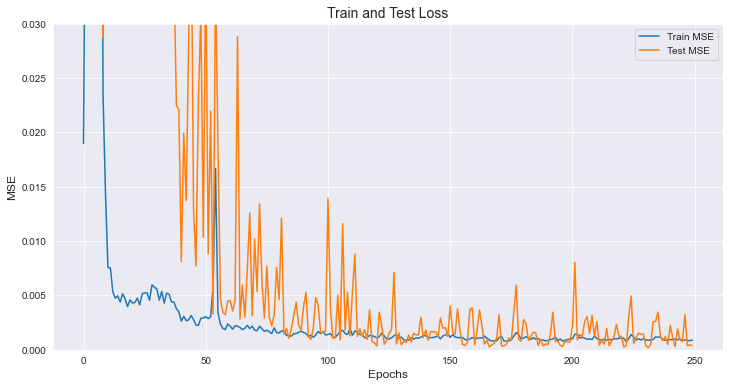

In [30]:
# Plot train and test loss (Mean Squared Error)
sns.set_style('darkgrid')
plt.figure(figsize= (12, 6))
plt.title('Train and Test Loss', fontsize= 14)
plt.plot(history.history['loss'], label= 'Train MSE')
plt.plot(history.history['val_loss'], label= 'Test MSE')
plt.ylabel('MSE', fontsize= 12)
plt.xlabel('Epochs', fontsize= 12)
plt.legend()
plt.ylim(0, .03)
plt.savefig('../visualizations/study_model_loss.jpg', bbox_inches='tight');

In [21]:
# Create a dataframe that will hold the predictions for y as well as the original values for X
test_results_sc = pd.DataFrame(X_test[win_length:])
test_results_sc[2] = test_preds

In [22]:
test_results_sc.head()

,0,1,2,3,4,5
0,0.027153,0.0,0.095843,0.0,0.050575,0.102258
1,0.027541,0.0,0.095523,0.0,0.050287,0.124834
2,0.027929,0.0,0.098685,0.0,0.050862,0.167331
3,0.028317,0.0,0.099965,0.0,0.051314,0.203187
4,0.028704,0.0,0.102625,0.0,0.051642,0.232404


In [23]:
# Now we need to de-scale the data for interpretability
# Column '2' is y_test predictions, de-scaled
test_results = pd.DataFrame(mm_scaler.inverse_transform(test_results_sc))
test_results.head()

,0,1,2,3,4,5
0,72.0,0.0,475.378131,0.0,69.400000,16.10
1,73.0,0.0,474.259247,0.0,69.375000,16.95
2,74.0,0.0,485.318351,0.0,69.425000,18.55
3,75.0,0.0,489.791597,0.0,69.464286,19.90
4,76.0,0.0,499.094896,0.0,69.492857,21.00


In [24]:
# This is y_test, de-scaled (Original)
pd.DataFrame(test_df['Oxygen'][win_length:]).reset_index().drop('index', axis= 1)

,Oxygen
0,468.400000
1,475.875000
2,481.325000
3,491.878571
4,507.535714
...,...
2504,471.150000
2505,446.833333
2506,416.500000
2507,377.571429


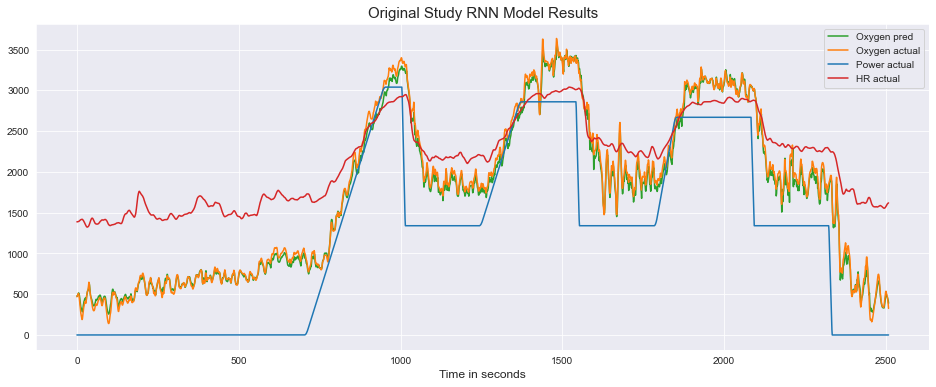

In [25]:
# Visualize the predictions and original data
sns.set_style('darkgrid')
plt.figure(figsize= (16, 6))
plt.title('Original Study RNN Model Results', fontsize= 15)
plt.plot(test_results[2], color = 'tab:green', label= 'Oxygen pred')
plt.plot(pd.DataFrame(test_df['Oxygen'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:orange', label= 'Oxygen actual')
plt.plot(pd.DataFrame(test_df['Power'][win_length:]).reset_index().drop('index', axis= 1) * 10, color= 'tab:blue', label= 'Power actual')
plt.plot(pd.DataFrame(test_df['HR'][win_length:]).reset_index().drop('index', axis= 1) * 20, color= 'tab:red', label= 'HR actual')
#plt.ylim(50, 160)
plt.xlabel('Time in seconds', fontsize= 12)
plt.legend()
plt.savefig('../visualizations/study_rnn_model_results.jpg', bbox_inches='tight');

#### Save the Model

In [26]:
model.save('../models/study_model/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/study_model/assets


In [27]:
# Reload model and test it for verification
reconstructed_model = keras.models.load_model('../models/study_model/')

In [28]:
recon_train_preds = reconstructed_model.predict(train_generator)
recon_test_preds = reconstructed_model.predict(test_generator)

In [29]:
# Train and Test r2 scores
r2_score(y_train[win_length:], recon_train_preds), r2_score(y_test[win_length:], recon_test_preds)

(0.9957326601417098, 0.9950051758762474)